a)
The print of the classes and functions of the code is provided below. The rest of the code that uses these functions and classes are provided in the subsequent sections to avoid repetition when running this jupyter notebook.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

class TreeNode():
    """
    This class represents a node and is used to store and retrieve the properties of each node including its child nodes
    """
    def __init__(self):
        self.split_number = None
        self.has_best_word = None
        self.best_word = None
        self.best_gain = None
        self.point_est = None
        self.children = []

    def set_best_split(self, doc_words, doc_classes, weighted):
        """
        Finds the best candidate feature that results in the highest information gain

        :param doc_words: a dictionary of doc id and corresponding word ids
        :type doc_words: Dicationary
        :param doc_classes: A dictionary of doc id and corresponding classes
        :type doc_classes: Dictionary
        """
        best_gain = 0
        best_word_id = None
        for word_id in set(word for words in doc_words.values() for word in words):
            gain = eval_info_gain(doc_words, doc_classes, word_id, weighted)
            if gain > best_gain:
                best_gain = gain
                best_word_id = word_id
        self.best_gain = best_gain
        self.best_word = best_word_id
    
    def get_split_number(self):
        return self.split_number
    
    def set_split_number(self, i_node):
        self.split_number = i_node

    def set_yes_branch(self, has_word:bool):
        self.has_best_word = has_word

    def get_has_best_word(self):
        return self.has_best_word
    
    def add_children(self, children_list:list):
        self.children += children_list

    def set_point_est(self, point_est):
        self.point_est = point_est

    def get_point_est(self):
        return self.point_est

    def set_best_word(self, word):
        self.best_word = word

    def get_best_word(self):
        return self.best_word
    
    def get_best_gain(self):
        return self.best_gain


class TreeModel():
    """
    This class provides methods for training a decision tree and reporting the results
    """
    def __init__(self):
        self.root_node = TreeNode()
    
    def fit(self, doc_words, doc_classes, max_splits: int, weighted: bool):
        """
        Trains the decision tree by using the priority list of leaves. At each itereation a leaf is split into two new ones.
        each split should result in the highest information gain that is possible.

        :param doc_words: A dictionary of doc ID and its corresponding list of words
        :type doc_words: dictionary
        :param doc_classes: A dictionary of doc ID and its corresponding class
        :type doc_classes: dictionary
        :param max_splits: number of splits performed in construction of the model
        :type max_splits: Integer      
        """
        # total_time = 0
        # n_iter = 0
        priority_leaves = []
        root_node = self.root_node

        # Set properties of the root_node
        root_node.set_point_est(eval_point_est(doc_words, doc_classes))
        root_node.set_best_split(doc_words, doc_classes, weighted)
        leaf = {"node": root_node,
                "doc_words": doc_words}
        priority_leaves.append(leaf)

        # Iterate 100 times and split based on PQ
        for idx in tqdm(range(max_splits)):
            iter = idx + 1
            if len(priority_leaves) == 0:
                break

            # Sort the priority leaves and select the one with the highest information gain
            if len(priority_leaves) > 1: 
                priority_leaves = sorted(priority_leaves, key=lambda x: x["node"].get_best_gain(), reverse=True)
            best_leaf = priority_leaves.pop(0)
            node = best_leaf["node"]

            if node.get_best_gain() > 0:
                node.set_split_number(iter)
                split_leaves = split_leaf(best_leaf, doc_classes, weighted)
                node.add_children([leaf["node"] for leaf in split_leaves])
                priority_leaves += split_leaves
            else:
                break
        self.root_node = root_node

    def get_root_node(self):
        return self.root_node
    
    def predict(self, words: list, max_splits: int):
        """
        Gets list of words of in a document and returns the estimated class

        :param words: a list of words corrosponding to a doc ID
        :type words: list
        :param max_splits: number of splits to use for classification
        :type max_splits: Integer
        """
        n_splits = 0
        node = self.root_node
        while len(node.children) > 0 and (n_splits <= max_splits):
             # Select the child that contain or not contain the word simultaneously with the document.
            if  (node.best_word in words) == node.children[0].has_best_word:
                node = node.children[0]
            else:
                node = node.children[1]
            n_splits += 1
        return node.get_point_est()[0]
    
    def eval_accuracy(self, doc_words: dict, doc_classes: dict, max_splits:int):
        """
        Gets the labeled data and evaluates the classification accuracy of the model as the ratio of correct estimates to the total number of documents

        :param doc_words: A dictionary of doc ID and its corresponding list of words
        :type doc_words: dictionary
        :param doc_classes: A dictionary of doc ID and its corresponding class
        :type doc_classes: dictionary
        :param max_splits: number of splits to use for classification
        :type max_splits: Integer
        """
        n_success = 0
        for doc_id, words in doc_words.items():
            if self.predict(words, max_splits) == doc_classes[doc_id]:
                n_success += 1
        return n_success/len(doc_words)


    def plot_graph(self, wordid_word, max_splits: int):
        """
        Plots the decision tree graph of the trained model

        :param wordid_word: a dictionary that maps word ids to the words
        :type wordid_word: Dictionary
        :param max_splits: maximum number of splits that are shown in the graph
        :type max_splits: Integer
        """
    # Create a directed graph
        G = nx.DiGraph()
        create_graph(G, [self.root_node], wordid_word, max_splits)
        # Draw the tree
        plt.figure(figsize=(10, 8))
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
        nx.draw(G, pos, with_labels=False, node_size=3000, node_color='skyblue', alpha=0.5, font_size=4, font_color="black")
        nx.draw_networkx_labels(G, pos, labels={n: f"{G.nodes[n]['best_word']}\ngain:{G.nodes[n]['gain']}\nsplit:{G.nodes[n]['num']}\nest:{G.nodes[n]['est']}" for n in G.nodes()})
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): G.edges[u, v]["have"] for u, v in G.edges()})

        # Create custom legend
        custom_handles = [plt.Line2D([], [], marker='', color='none', label='est 1: atheism'),
                        plt.Line2D([], [], marker='', color='none', label='est 2: books')]
        plt.legend(handles=custom_handles)
        
        plt.axis("off")
        plt.show()
        plt.savefig("accuracy_{method_str}.png")

def eval_info(class_labels: list):
    """
    Evaluates the info (entropy) within a list of classes(labels)

    :param class_labels: list of classes in a given node (split)
    :type class_labels: List
    """
    n1 = class_labels.count(1)
    n2 = class_labels.count(2)
    if (n1 == 0) or (n2 == 0):
        info = 0
    else:
        n = n1 + n2
        pr1 = n1/n
        pr2 = n2/n
        info = -(pr1 * np.log2(pr1) + (pr2) * np.log2(pr2))
    return info

def eval_info_gain(doc_words: dict, doc_classes: dict, word_id, weighted:bool):
    """
    Calculates the information gain after spliting by word_id

    :param doc_words: a dictionary of doc id and corresponding word ids
    :type doc_words: Dicationary
    :param doc_classes: A dictionary of doc id and corresponding classes
    :type doc_classes: Dictionary
    :param word_id: The word id by which the doc_words is split into two new doc_words
    :type word_id: Integer
    :param weighted: Specifies whether the weighted method is used in calcualtion of information gain or the average method is used.
    :type weighted: Boolean
    """
    yes_word, no_word = [], []
    for doc_id, words in doc_words.items():
        if word_id in words:
            yes_word.append(doc_id)
        else:
            no_word.append(doc_id)
    
    # Calculate information before split
    init_info = eval_info([doc_classes[doc_id] for doc_id in doc_words.keys()])
    
    # Calculate weighted information after split
    yes_word_info = eval_info([doc_classes[doc_id] for doc_id in yes_word])
    no_word_info = eval_info([doc_classes[doc_id] for doc_id in no_word])
    if weighted:
        new_info = (len(yes_word) * yes_word_info + len(no_word) * no_word_info) / len(doc_words)
    else:
        new_info = 0.5*(yes_word_info + no_word_info)
    
    # Information gain
    return init_info - new_info

def split_leaf(leaf, doc_classes, weighted):
    """
    Splits a tree leaf into two leaves and returns the new two leaves

    :param leaf: a leaf contains a doc_word dictionary and the corresponding node that contains doc_word data
    :type leaf: dictionary
    :param doc_classes: A dictionary of doc id and corresponding classes
    :type doc_classes: Dictionary
    :param weighted: shows wheter weighted method is used
    :type weighted: Boolean
    """
    doc_words = leaf["doc_words"]
    best_word_id = leaf["node"].get_best_word()

    doc_has = {}
    doc_has_no = {}
    leaves = []

    # Split doc ids based on the possession of the best word id
    for doc_id, word_ids in doc_words.items():
        if best_word_id in word_ids:
            # Documents that have the best word
            doc_has[doc_id] = word_ids
        else:
            # Documents that dont have the best word
            doc_has_no[doc_id] = word_ids

    # Set the node properties of each branch and create a new leaf for the PQ
    for has_word in [True, False]:
        leaf = {}
        doc = doc_has if has_word else doc_has_no
        node = TreeNode()
        node.set_point_est(eval_point_est(doc, doc_classes))
        node.set_best_split(doc, doc_classes, weighted)
        node.set_yes_branch(has_word)
        leaf["doc_words"] = doc
        leaf["node"] = node
        leaves += [leaf]

    return leaves

def find_mode(item):
    return max(set(item), key=item.count)

def eval_point_est(doc_word: dict, doc_classes: dict):
    """
    Evaluates the point estimate bases on the mode of the classes in the input dictionary of classes

    :param doc_word: A dictionary of the portion of the doc id word id pairs in a node (split)
    :type doc_word: Dictionary
    :param doc_classes: A dictionary of doc id and corresponding classes
    :type doc_classes: Dictionary
    """
    # find the mode and if there are multiple modes return the first one in the list
    doc_ids = list(doc_word.keys())
    mode = find_mode([doc_classes[doc_id] for doc_id in doc_ids]) if doc_ids else None
    
    # evaluate the probablity of the mode
    p = doc_ids.count(mode)/len(doc_ids) if doc_ids else None
    return (mode, p)

def create_graph(G, nodes: list, wordid_word: dict, max_splits: int):
    """
    Takes a node and creates the networkx graph from that node to the bottom by 10 splits

    :param nodes: List of nodes sorted based on their split number in ascending order
    :type nodes: list
    :param wordid_word: A dictionary that maps word ids to the words
    :type wordid_word: Dictionary
    :param max_splits: Max number of splits that the graph will show from the root node
    :type max_splits: Integer
    """
    node = nodes.pop(0)
    node_split_num = node.get_split_number()
    node_word = wordid_word[node.get_best_word()] if node.get_best_word() else ""
    node_gain = node.get_best_gain()

    # Add the node if not already in the graph
    if id(node) not in G:
        G.add_node(id(node), num=node_split_num, est=node.get_point_est()[0],
                   p=node.get_point_est()[1], best_word=node_word, gain=round(node_gain, 2))

    # Add children to the graph
    children = node.children
    for child in children:
        child_word = wordid_word[child.get_best_word()] if child.get_best_word() else ""
        child_gain = child.get_best_gain()
        child_split_num = child.get_split_number()
        # Set child labels based on being internal nodes or not
        if ((child_split_num is None) or (child_split_num <= max_splits)) and (child_gain > 0):
            G.add_node(id(child), num=child_split_num, est=child.get_point_est()[0],
                       p=child.get_point_est()[1], best_word=child_word, gain=round(child_gain, 2))
        else:
            G.add_node(id(child), num="", est=child.get_point_est()[0], p=child.get_point_est()[1], best_word="", gain="")
        have_str = "yes" if child.has_best_word else "no"
        G.add_edge(id(node), id(child), have=f"{have_str}")
    
    if node_split_num < max_splits:
        # Go to next split if max splits not reached yet
        nodes += [child_i for child_i in children if child_i.get_split_number()]
        nodes.sort(key=lambda x: x.get_split_number())
        create_graph(G, nodes, wordid_word, max_splits)

def parse_data(doc_word_file, doc_class_file, words_file):
    """
    Parses all input data and converts them to appropriate data types

    :param doc_word_file: Path of the file that contains the word ids associated with each document ids
    :type doc_word_file: String
    :param doc_class_file: Path of the file that contains classes(label) associated with each document ids
    :type doc_word_file: String
    :param words_file: Path of the file that contains the words associated the word ids
    :type doc_word_file: String
    """
    # Parse the docID and wordID pairs
    doc_words = {}
    with open(doc_word_file, 'r') as f:
        for line in f:
            doc_id, word_id = map(int, line.strip().split())
            if doc_id not in doc_words:
                doc_words[doc_id] = []
            doc_words[doc_id].append(word_id)
    
    # Parse the docID and its class
    doc_classes = {}
    with open(doc_class_file, 'r') as f:
        for idx, class_id in enumerate(f):
            doc_id, class_id = (idx+1, int(class_id.strip()))
            doc_classes[doc_id] = class_id

    word_id_words = {}
    with open(words_file, 'r') as f:
        for id, word in enumerate(f):
            word_id, word = (id+1, word.strip())
            word_id_words[word_id] = word
    
    return doc_words, doc_classes, word_id_words

b)
Two different tree learner objects are created: one for weighted average and the other one for non-weighted. The accuracy is obtained for both methods using both training data and testing data.

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


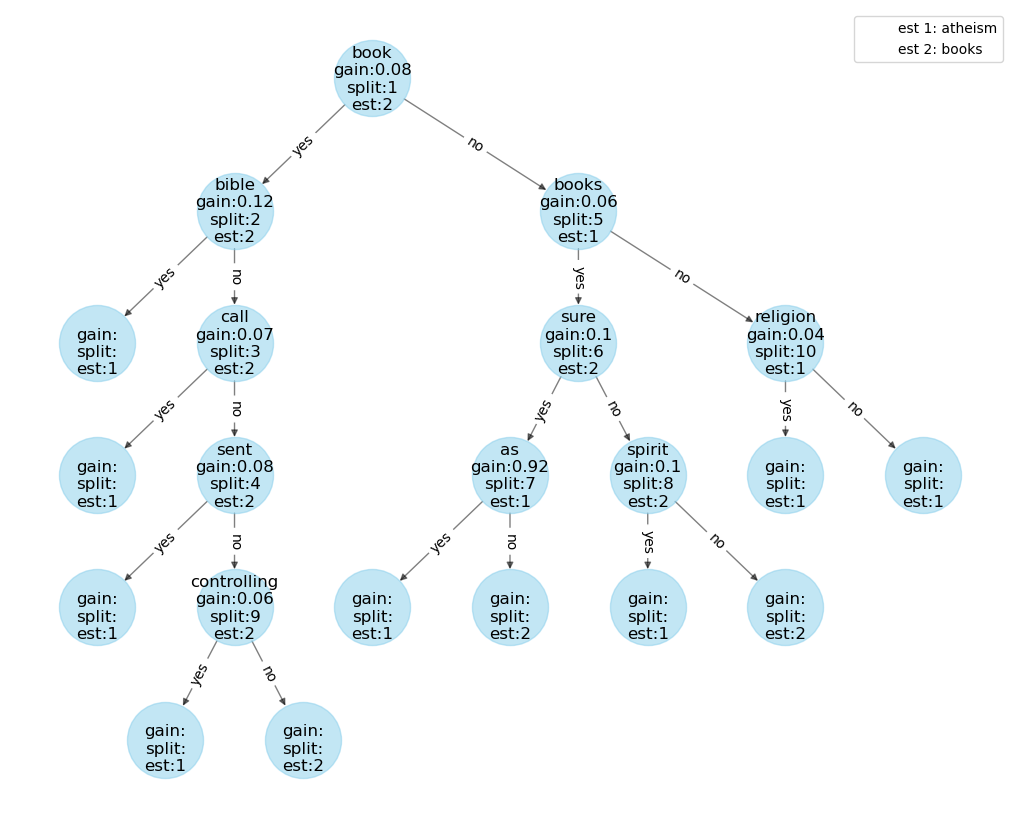

Training Accuracy (Weighted): 84.32%, Testing Accuracy (Weighted): 69.79%


100%|██████████| 100/100 [03:41<00:00,  2.22s/it]


<Figure size 640x480 with 0 Axes>

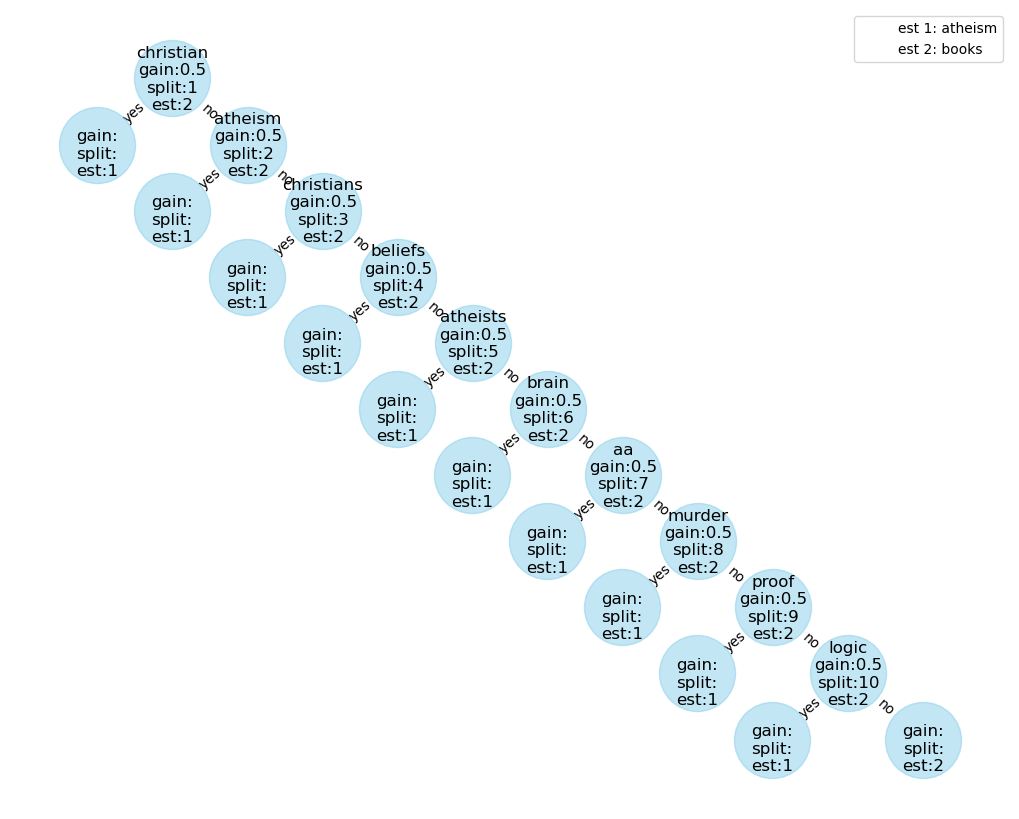

Training Accuracy (Non-weighted): 76.44%, Testing Accuracy (Non-weighted): 59.52%


<Figure size 640x480 with 0 Axes>

In [5]:
train_doc_words, train_doc_classes, id_words = parse_data("./dataset/trainData.txt",
                                                "./dataset/trainLabel.txt",
                                                "./dataset/words.txt")
test_doc_words, test_doc_classes, _ = parse_data("./dataset/testData.txt",
                                                "./dataset/testLabel.txt",
                                                "./dataset/words.txt")

tree_models = {}
for weighted in [True, False]:
    method_str = "Weighted" if weighted else "Non-weighted"
    tree_model = TreeModel()
    tree_model.fit(train_doc_words, train_doc_classes, 100, weighted)
    tree_model.plot_graph(id_words, 10)
    train_accuracy = tree_model.eval_accuracy(train_doc_words, train_doc_classes, max_splits=100)
    test_accuracy = tree_model.eval_accuracy(test_doc_words, test_doc_classes, max_splits=100)
    print(f"Training Accuracy ({method_str}): {100*train_accuracy:0.2f}%, Testing Accuracy ({method_str}): {100*test_accuracy:0.2f}%")
    tree_models[method_str] = tree_model

c)
Both of the models are trained by using trainData and trainLabel

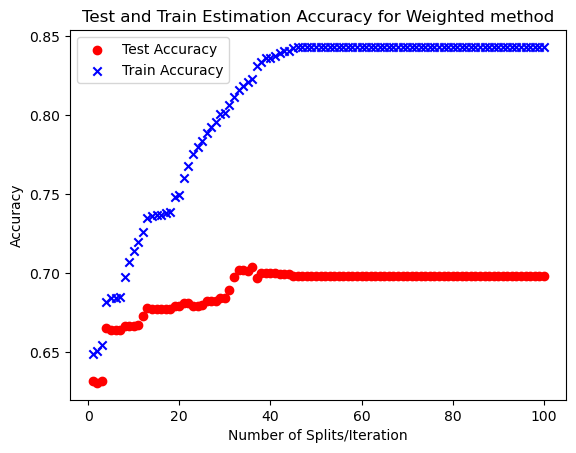

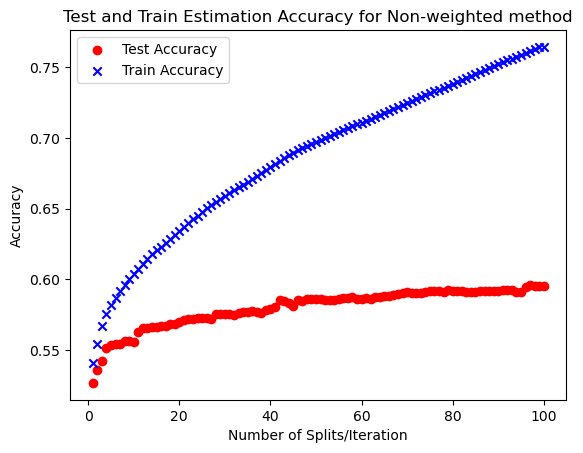

In [6]:
for method, tree_model in tree_models.items():
    # Plot accuracy charts
    x = np.arange(1, 101)
    y1 = [tree_model.eval_accuracy(test_doc_words, test_doc_classes, max_splits) for max_splits in x]
    y2 = [tree_model.eval_accuracy(train_doc_words, train_doc_classes, max_splits) for max_splits in x]
    fig, ax = plt.subplots()
    ax.scatter(x, y1, label='Test Accuracy', color='red', marker='o')
    ax.scatter(x, y2, label='Train Accuracy', color='blue', marker='x')
    ax.set_xlabel("Number of Splits/Iteration")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.set_title(f"Test and Train Estimation Accuracy for {method} method")